## 1D Inverse Terzaghi Consolidation Problem (PINN)

Here, we attempt to invert *one* parameter from the 1D Terzaghi PDE by using the physics to predict the unknown parameters from exact solution data. The real parameter value is 0.75.

In [1]:
import numpy as np
import sciann as sn
import matplotlib.pyplot as plt
from sciann.utils.math import sign, abs, sigmoid, tanh, diff

---------------------- SCIANN 0.7.0.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.12.0 
Python Version: 3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)] 



In [2]:
# ----------------------- Constant Parameters -------------------------
cv = 0.75
Ly = 2
p0 = 1.0
p_star = 1.0

y_min, y_max = 0., Ly
t_min, t_max = 0., 1.0

zs = np.linspace(y_min, y_max, 100)
ts = np.linspace(t_min, t_max, 100)

### Fourier Solution

In [3]:
def Uz(N,Z,T):
    uz = 0
    #function is zero for even values of n. Therefore only compute for odd values
    for n in range(1,N+1,2):
        uz += 4.0/np.pi/n*np.sin(np.pi*n/2.0*Z)*np.exp(-1.0*n*n*np.pi*np.pi/4.0*T)
    return uz

cv = 0.75 # consolidation m^2/year
H = Ly/2 # drainage path length
ts = np.linspace(0, 1, 100)
T = (cv*ts)/H**2
Z = zs
N = 50

time = ts
depth = zs

# Create the meshgrid for contour plot using 'ij' indexing
T_contour = np.array([[cv * t / (H**2) for t in time] for z in depth])
T_mesh, Z_mesh = np.meshgrid(time, depth, indexing='ij')
U_mesh = np.zeros_like(T_mesh)

# Calculate the analytical pressures
for i in range(len(time)):
    for j in range(len(depth)):
        U_mesh[i, j] = Uz(N, Z_mesh[i, j], T_contour[j, i])

### Randomly selecting training data

In [4]:
def PrepareData(num_data=5000, random=True):
    # Flattening the mesh grid
    Z, T = np.meshgrid(zs, ts)
    Z_flat = Z.flatten()[:, None]
    T_flat = T.flatten()[:, None]
    
    # Calculating U_mesh
    U_mesh_flat = U_mesh.flatten()[:, None]
    
    # Pick random data
    if random:
        idx = np.random.choice(Z_flat.shape[0], num_data, replace=False)
    else:
        idx = np.arange(0, Z_flat.shape[0])
    
    z_train = Z_flat[idx]
    t_train = T_flat[idx]
    u_train = U_mesh_flat[idx]
    
    return (z_train, t_train, u_train)

z_train, t_train, u_train = PrepareData(5000, random=True)

### Defining the physics

In [5]:
# Reset session and set random seed
sn.reset_session()
sn.set_random_seed(1234)

# Define independent variables
z = sn.Variable("z", dtype='float64')
t = sn.Variable("t", dtype='float64')

# Define solution variable
U = sn.Functional("U", [z, t], 8*[20], 'tanh')

# Define parameter to be inverted
cv_inv = sn.Parameter(1.2, inputs=[z, t], name="cv_inv")

# Define PDE (physics constraint)
U_t = diff(U, t)
U_z = diff(U, z)
U_zz = diff(U_z, z)

PDE = cv_inv * U_zz - U_t

# Define targets (losses) using sn.Data and sn.PDE interfaces
data_target = sn.Data(U)
pde_constraint = sn.PDE(PDE)

### Training the model

In [6]:
# Define the optimization model
model_inv = sn.SciModel(
    inputs=[z, t],
    targets=[data_target, pde_constraint], # usually all of above
    loss_func="mse"
)

input_data = [z_train, t_train]
target_data = [u_train, 'zeros'] # U = exact sol, PDE = 0

# Prepare the training input and target data
H_new = model_inv.train(
    input_data,
    target_data,
    epochs=1000,
    batch_size=500,
    stop_loss_value=1e-36,
    learning_rate=1e-3,
    stop_after=None,
    verbose=2,
    log_parameters={'parameters': cv_inv, 'freq': 1}
)

model_inv.save_weights('Inverse1DWeights.hdf5')


Total samples: 5000 
Batch size: 500 
Total batches: 10 

Epoch 1/1000
10/10 - 6s - loss: 0.1367 - U_loss: 0.1048 - sub_loss: 0.0319 - lr: 0.0010 - time: 5.5243 - cv_inv: 1.1908 - 6s/epoch - 557ms/step
Epoch 2/1000
10/10 - 0s - loss: 0.0660 - U_loss: 0.0615 - sub_loss: 0.0046 - lr: 0.0010 - time: 0.1887 - cv_inv: 1.1859 - 189ms/epoch - 19ms/step
Epoch 3/1000
10/10 - 0s - loss: 0.0599 - U_loss: 0.0528 - sub_loss: 0.0071 - lr: 0.0010 - time: 0.2662 - cv_inv: 1.1855 - 251ms/epoch - 25ms/step
Epoch 4/1000
10/10 - 0s - loss: 0.0562 - U_loss: 0.0507 - sub_loss: 0.0055 - lr: 0.0010 - time: 0.1889 - cv_inv: 1.1872 - 189ms/epoch - 19ms/step
Epoch 5/1000
10/10 - 0s - loss: 0.0543 - U_loss: 0.0496 - sub_loss: 0.0047 - lr: 0.0010 - time: 0.2041 - cv_inv: 1.1884 - 204ms/epoch - 20ms/step
Epoch 6/1000
10/10 - 0s - loss: 0.0522 - U_loss: 0.0467 - sub_loss: 0.0055 - lr: 0.0010 - time: 0.2044 - cv_inv: 1.1892 - 204ms/epoch - 20ms/step
Epoch 7/1000
10/10 - 0s - loss: 0.0502 - U_loss: 0.0436 - sub_loss:

Epoch 56/1000
10/10 - 0s - loss: 0.0032 - U_loss: 0.0029 - sub_loss: 2.9164e-04 - lr: 0.0010 - time: 0.2051 - cv_inv: 0.9211 - 205ms/epoch - 21ms/step
Epoch 57/1000
10/10 - 0s - loss: 0.0032 - U_loss: 0.0029 - sub_loss: 3.1358e-04 - lr: 0.0010 - time: 0.2004 - cv_inv: 0.9177 - 200ms/epoch - 20ms/step
Epoch 58/1000
10/10 - 0s - loss: 0.0033 - U_loss: 0.0030 - sub_loss: 3.0253e-04 - lr: 0.0010 - time: 0.2025 - cv_inv: 0.9142 - 202ms/epoch - 20ms/step
Epoch 59/1000
10/10 - 0s - loss: 0.0032 - U_loss: 0.0029 - sub_loss: 2.7644e-04 - lr: 0.0010 - time: 0.2046 - cv_inv: 0.9112 - 205ms/epoch - 20ms/step
Epoch 60/1000
10/10 - 0s - loss: 0.0033 - U_loss: 0.0030 - sub_loss: 2.6316e-04 - lr: 0.0010 - time: 0.1889 - cv_inv: 0.9081 - 189ms/epoch - 19ms/step
Epoch 61/1000
10/10 - 0s - loss: 0.0032 - U_loss: 0.0029 - sub_loss: 2.6255e-04 - lr: 0.0010 - time: 0.1889 - cv_inv: 0.9053 - 189ms/epoch - 19ms/step
Epoch 62/1000
10/10 - 0s - loss: 0.0035 - U_loss: 0.0032 - sub_loss: 2.9544e-04 - lr: 0.0010 -

Epoch 111/1000
10/10 - 0s - loss: 0.0027 - U_loss: 0.0025 - sub_loss: 1.9412e-04 - lr: 0.0010 - time: 0.2156 - cv_inv: 0.8223 - 216ms/epoch - 22ms/step
Epoch 112/1000
10/10 - 0s - loss: 0.0028 - U_loss: 0.0025 - sub_loss: 2.3097e-04 - lr: 0.0010 - time: 0.2000 - cv_inv: 0.8213 - 200ms/epoch - 20ms/step
Epoch 113/1000
10/10 - 0s - loss: 0.0026 - U_loss: 0.0025 - sub_loss: 1.4608e-04 - lr: 0.0010 - time: 0.1956 - cv_inv: 0.8205 - 197ms/epoch - 20ms/step
Epoch 114/1000
10/10 - 0s - loss: 0.0026 - U_loss: 0.0024 - sub_loss: 1.3778e-04 - lr: 0.0010 - time: 0.2023 - cv_inv: 0.8196 - 202ms/epoch - 20ms/step
Epoch 115/1000
10/10 - 0s - loss: 0.0025 - U_loss: 0.0024 - sub_loss: 1.3528e-04 - lr: 0.0010 - time: 0.1924 - cv_inv: 0.8187 - 192ms/epoch - 19ms/step
Epoch 116/1000
10/10 - 0s - loss: 0.0026 - U_loss: 0.0024 - sub_loss: 1.4893e-04 - lr: 0.0010 - time: 0.1960 - cv_inv: 0.8178 - 196ms/epoch - 20ms/step
Epoch 117/1000
10/10 - 0s - loss: 0.0026 - U_loss: 0.0024 - sub_loss: 1.6099e-04 - lr: 0

Epoch 165/1000
10/10 - 0s - loss: 0.0023 - U_loss: 0.0021 - sub_loss: 2.0605e-04 - lr: 0.0010 - time: 0.2052 - cv_inv: 0.7920 - 204ms/epoch - 20ms/step
Epoch 166/1000
10/10 - 0s - loss: 0.0023 - U_loss: 0.0021 - sub_loss: 1.8824e-04 - lr: 0.0010 - time: 0.1950 - cv_inv: 0.7917 - 201ms/epoch - 20ms/step
Epoch 167/1000
10/10 - 0s - loss: 0.0023 - U_loss: 0.0021 - sub_loss: 1.8716e-04 - lr: 0.0010 - time: 0.1941 - cv_inv: 0.7914 - 187ms/epoch - 19ms/step
Epoch 168/1000
10/10 - 0s - loss: 0.0021 - U_loss: 0.0020 - sub_loss: 1.6649e-04 - lr: 0.0010 - time: 0.2088 - cv_inv: 0.7911 - 209ms/epoch - 21ms/step
Epoch 169/1000
10/10 - 0s - loss: 0.0022 - U_loss: 0.0020 - sub_loss: 1.5765e-04 - lr: 0.0010 - time: 0.1985 - cv_inv: 0.7906 - 198ms/epoch - 20ms/step
Epoch 170/1000
10/10 - 0s - loss: 0.0022 - U_loss: 0.0020 - sub_loss: 1.7233e-04 - lr: 0.0010 - time: 0.1937 - cv_inv: 0.7904 - 194ms/epoch - 19ms/step
Epoch 171/1000
10/10 - 0s - loss: 0.0021 - U_loss: 0.0020 - sub_loss: 1.5821e-04 - lr: 0

Epoch 219/1000
10/10 - 0s - loss: 0.0017 - U_loss: 0.0015 - sub_loss: 2.2791e-04 - lr: 0.0010 - time: 0.1995 - cv_inv: 0.7735 - 202ms/epoch - 20ms/step
Epoch 220/1000
10/10 - 0s - loss: 0.0017 - U_loss: 0.0015 - sub_loss: 2.0339e-04 - lr: 0.0010 - time: 0.1997 - cv_inv: 0.7731 - 204ms/epoch - 20ms/step
Epoch 221/1000
10/10 - 0s - loss: 0.0017 - U_loss: 0.0015 - sub_loss: 1.6890e-04 - lr: 0.0010 - time: 0.1994 - cv_inv: 0.7729 - 205ms/epoch - 20ms/step
Epoch 222/1000
10/10 - 0s - loss: 0.0018 - U_loss: 0.0015 - sub_loss: 2.5900e-04 - lr: 0.0010 - time: 0.1953 - cv_inv: 0.7726 - 195ms/epoch - 19ms/step
Epoch 223/1000
10/10 - 0s - loss: 0.0017 - U_loss: 0.0015 - sub_loss: 2.0234e-04 - lr: 0.0010 - time: 0.1981 - cv_inv: 0.7722 - 198ms/epoch - 20ms/step
Epoch 224/1000
10/10 - 0s - loss: 0.0017 - U_loss: 0.0015 - sub_loss: 2.4736e-04 - lr: 0.0010 - time: 0.2022 - cv_inv: 0.7718 - 202ms/epoch - 20ms/step
Epoch 225/1000
10/10 - 0s - loss: 0.0017 - U_loss: 0.0015 - sub_loss: 2.0998e-04 - lr: 0

Epoch 273/1000
10/10 - 0s - loss: 0.0014 - U_loss: 0.0012 - sub_loss: 1.8555e-04 - lr: 0.0010 - time: 0.1907 - cv_inv: 0.7617 - 191ms/epoch - 19ms/step
Epoch 274/1000
10/10 - 0s - loss: 0.0015 - U_loss: 0.0013 - sub_loss: 2.6993e-04 - lr: 0.0010 - time: 0.2009 - cv_inv: 0.7615 - 185ms/epoch - 19ms/step
Epoch 275/1000
10/10 - 0s - loss: 0.0014 - U_loss: 0.0012 - sub_loss: 1.7083e-04 - lr: 0.0010 - time: 0.1845 - cv_inv: 0.7615 - 200ms/epoch - 20ms/step
Epoch 276/1000
10/10 - 0s - loss: 0.0015 - U_loss: 0.0013 - sub_loss: 2.5513e-04 - lr: 0.0010 - time: 0.1962 - cv_inv: 0.7614 - 189ms/epoch - 19ms/step
Epoch 277/1000
10/10 - 0s - loss: 0.0016 - U_loss: 0.0013 - sub_loss: 2.8815e-04 - lr: 0.0010 - time: 0.1999 - cv_inv: 0.7613 - 200ms/epoch - 20ms/step
Epoch 278/1000
10/10 - 0s - loss: 0.0014 - U_loss: 0.0012 - sub_loss: 1.8325e-04 - lr: 0.0010 - time: 0.2006 - cv_inv: 0.7611 - 191ms/epoch - 19ms/step
Epoch 279/1000
10/10 - 0s - loss: 0.0014 - U_loss: 0.0012 - sub_loss: 1.8919e-04 - lr: 0

Epoch 327/1000
10/10 - 0s - loss: 0.0013 - U_loss: 0.0011 - sub_loss: 1.5649e-04 - lr: 0.0010 - time: 0.2042 - cv_inv: 0.7574 - 204ms/epoch - 20ms/step
Epoch 328/1000
10/10 - 0s - loss: 0.0014 - U_loss: 0.0012 - sub_loss: 2.2268e-04 - lr: 0.0010 - time: 0.2005 - cv_inv: 0.7574 - 200ms/epoch - 20ms/step
Epoch 329/1000
10/10 - 0s - loss: 0.0014 - U_loss: 0.0011 - sub_loss: 2.5722e-04 - lr: 0.0010 - time: 0.2012 - cv_inv: 0.7574 - 201ms/epoch - 20ms/step
Epoch 330/1000
10/10 - 0s - loss: 0.0013 - U_loss: 0.0011 - sub_loss: 2.1484e-04 - lr: 0.0010 - time: 0.2004 - cv_inv: 0.7574 - 200ms/epoch - 20ms/step
Epoch 331/1000
10/10 - 0s - loss: 0.0012 - U_loss: 0.0011 - sub_loss: 1.5609e-04 - lr: 0.0010 - time: 0.1914 - cv_inv: 0.7573 - 191ms/epoch - 19ms/step
Epoch 332/1000
10/10 - 0s - loss: 0.0013 - U_loss: 0.0011 - sub_loss: 1.9512e-04 - lr: 0.0010 - time: 0.1981 - cv_inv: 0.7573 - 198ms/epoch - 20ms/step
Epoch 333/1000
10/10 - 0s - loss: 0.0013 - U_loss: 0.0011 - sub_loss: 2.3505e-04 - lr: 0

Epoch 381/1000
10/10 - 0s - loss: 0.0011 - U_loss: 9.5849e-04 - sub_loss: 1.7447e-04 - lr: 0.0010 - time: 0.1952 - cv_inv: 0.7547 - 195ms/epoch - 20ms/step
Epoch 382/1000
10/10 - 0s - loss: 0.0011 - U_loss: 9.5614e-04 - sub_loss: 1.7814e-04 - lr: 0.0010 - time: 0.1911 - cv_inv: 0.7546 - 191ms/epoch - 19ms/step
Epoch 383/1000
10/10 - 0s - loss: 0.0014 - U_loss: 0.0011 - sub_loss: 3.3767e-04 - lr: 0.0010 - time: 0.2123 - cv_inv: 0.7545 - 212ms/epoch - 21ms/step
Epoch 384/1000
10/10 - 0s - loss: 0.0014 - U_loss: 0.0010 - sub_loss: 3.6404e-04 - lr: 0.0010 - time: 0.1994 - cv_inv: 0.7548 - 198ms/epoch - 20ms/step
Epoch 385/1000
10/10 - 0s - loss: 0.0017 - U_loss: 0.0011 - sub_loss: 5.9852e-04 - lr: 0.0010 - time: 0.1894 - cv_inv: 0.7548 - 189ms/epoch - 19ms/step
Epoch 386/1000
10/10 - 0s - loss: 0.0012 - U_loss: 9.6645e-04 - sub_loss: 2.7300e-04 - lr: 0.0010 - time: 0.2083 - cv_inv: 0.7547 - 208ms/epoch - 21ms/step
Epoch 387/1000
10/10 - 0s - loss: 0.0012 - U_loss: 9.5587e-04 - sub_loss: 1.

Epoch 434/1000
10/10 - 0s - loss: 0.0012 - U_loss: 8.9650e-04 - sub_loss: 3.0783e-04 - lr: 0.0010 - time: 0.1960 - cv_inv: 0.7536 - 196ms/epoch - 20ms/step
Epoch 435/1000
10/10 - 0s - loss: 0.0010 - U_loss: 8.5463e-04 - sub_loss: 1.5378e-04 - lr: 0.0010 - time: 0.1948 - cv_inv: 0.7536 - 195ms/epoch - 19ms/step
Epoch 436/1000
10/10 - 0s - loss: 0.0012 - U_loss: 9.1501e-04 - sub_loss: 3.0897e-04 - lr: 0.0010 - time: 0.2132 - cv_inv: 0.7537 - 213ms/epoch - 21ms/step
Epoch 437/1000
10/10 - 0s - loss: 0.0011 - U_loss: 8.7523e-04 - sub_loss: 2.0447e-04 - lr: 0.0010 - time: 0.2048 - cv_inv: 0.7535 - 193ms/epoch - 19ms/step
Epoch 438/1000
10/10 - 0s - loss: 9.6640e-04 - U_loss: 8.3285e-04 - sub_loss: 1.3355e-04 - lr: 0.0010 - time: 0.2040 - cv_inv: 0.7535 - 200ms/epoch - 20ms/step
Epoch 439/1000
10/10 - 0s - loss: 0.0011 - U_loss: 8.9161e-04 - sub_loss: 2.4020e-04 - lr: 0.0010 - time: 0.1941 - cv_inv: 0.7534 - 187ms/epoch - 19ms/step
Epoch 440/1000
10/10 - 0s - loss: 0.0012 - U_loss: 9.3071e-0

Epoch 487/1000
10/10 - 0s - loss: 9.0870e-04 - U_loss: 7.8736e-04 - sub_loss: 1.2134e-04 - lr: 0.0010 - time: 0.2021 - cv_inv: 0.7528 - 199ms/epoch - 20ms/step
Epoch 488/1000
10/10 - 0s - loss: 9.1190e-04 - U_loss: 7.7113e-04 - sub_loss: 1.4077e-04 - lr: 0.0010 - time: 0.2011 - cv_inv: 0.7528 - 202ms/epoch - 20ms/step
Epoch 489/1000
10/10 - 0s - loss: 9.7378e-04 - U_loss: 7.9609e-04 - sub_loss: 1.7770e-04 - lr: 0.0010 - time: 0.1967 - cv_inv: 0.7529 - 189ms/epoch - 19ms/step
Epoch 490/1000
10/10 - 0s - loss: 9.6778e-04 - U_loss: 8.0152e-04 - sub_loss: 1.6626e-04 - lr: 0.0010 - time: 0.2016 - cv_inv: 0.7528 - 196ms/epoch - 20ms/step
Epoch 491/1000
10/10 - 0s - loss: 0.0010 - U_loss: 8.1443e-04 - sub_loss: 2.2778e-04 - lr: 0.0010 - time: 0.1838 - cv_inv: 0.7528 - 184ms/epoch - 18ms/step
Epoch 492/1000
10/10 - 0s - loss: 0.0011 - U_loss: 8.4796e-04 - sub_loss: 2.6011e-04 - lr: 0.0010 - time: 0.2228 - cv_inv: 0.7528 - 217ms/epoch - 22ms/step
Epoch 493/1000
10/10 - 0s - loss: 0.0011 - U_los

Epoch 539/1000
10/10 - 0s - loss: 9.2260e-04 - U_loss: 7.6499e-04 - sub_loss: 1.5761e-04 - lr: 0.0010 - time: 0.1923 - cv_inv: 0.7527 - 192ms/epoch - 19ms/step
Epoch 540/1000
10/10 - 0s - loss: 0.0011 - U_loss: 8.1341e-04 - sub_loss: 2.9880e-04 - lr: 0.0010 - time: 0.2526 - cv_inv: 0.7527 - 253ms/epoch - 25ms/step
Epoch 541/1000
10/10 - 0s - loss: 0.0019 - U_loss: 0.0010 - sub_loss: 9.1278e-04 - lr: 0.0010 - time: 0.2018 - cv_inv: 0.7528 - 202ms/epoch - 20ms/step
Epoch 542/1000
10/10 - 0s - loss: 0.0011 - U_loss: 8.4453e-04 - sub_loss: 3.0031e-04 - lr: 0.0010 - time: 0.1893 - cv_inv: 0.7528 - 189ms/epoch - 19ms/step
Epoch 543/1000
10/10 - 0s - loss: 0.0010 - U_loss: 8.0487e-04 - sub_loss: 2.2637e-04 - lr: 0.0010 - time: 0.1895 - cv_inv: 0.7529 - 189ms/epoch - 19ms/step
Epoch 544/1000
10/10 - 0s - loss: 0.0010 - U_loss: 7.6972e-04 - sub_loss: 2.3488e-04 - lr: 0.0010 - time: 0.2050 - cv_inv: 0.7528 - 205ms/epoch - 20ms/step
Epoch 545/1000
10/10 - 0s - loss: 8.7275e-04 - U_loss: 7.5195e-0

Epoch 591/1000
10/10 - 0s - loss: 8.9134e-04 - U_loss: 7.0294e-04 - sub_loss: 1.8841e-04 - lr: 0.0010 - time: 0.2052 - cv_inv: 0.7525 - 205ms/epoch - 21ms/step
Epoch 592/1000
10/10 - 0s - loss: 8.6453e-04 - U_loss: 6.8881e-04 - sub_loss: 1.7572e-04 - lr: 0.0010 - time: 0.2049 - cv_inv: 0.7525 - 205ms/epoch - 20ms/step
Epoch 593/1000
10/10 - 0s - loss: 0.0012 - U_loss: 7.9725e-04 - sub_loss: 3.7658e-04 - lr: 0.0010 - time: 0.2051 - cv_inv: 0.7524 - 205ms/epoch - 21ms/step
Epoch 594/1000
10/10 - 0s - loss: 9.8174e-04 - U_loss: 7.1486e-04 - sub_loss: 2.6688e-04 - lr: 0.0010 - time: 0.2045 - cv_inv: 0.7523 - 204ms/epoch - 20ms/step
Epoch 595/1000
10/10 - 0s - loss: 0.0010 - U_loss: 7.4890e-04 - sub_loss: 2.6523e-04 - lr: 0.0010 - time: 0.2051 - cv_inv: 0.7523 - 205ms/epoch - 21ms/step
Epoch 596/1000
10/10 - 0s - loss: 9.2500e-04 - U_loss: 7.0641e-04 - sub_loss: 2.1860e-04 - lr: 0.0010 - time: 0.2085 - cv_inv: 0.7523 - 209ms/epoch - 21ms/step
Epoch 597/1000
10/10 - 0s - loss: 0.0016 - U_los

Epoch 643/1000
10/10 - 0s - loss: 8.5670e-04 - U_loss: 6.8602e-04 - sub_loss: 1.7067e-04 - lr: 0.0010 - time: 0.2226 - cv_inv: 0.7521 - 223ms/epoch - 22ms/step
Epoch 644/1000
10/10 - 0s - loss: 8.1479e-04 - U_loss: 6.8539e-04 - sub_loss: 1.2939e-04 - lr: 0.0010 - time: 0.3015 - cv_inv: 0.7520 - 302ms/epoch - 30ms/step
Epoch 645/1000
10/10 - 0s - loss: 8.1766e-04 - U_loss: 6.8348e-04 - sub_loss: 1.3417e-04 - lr: 0.0010 - time: 0.1731 - cv_inv: 0.7521 - 173ms/epoch - 17ms/step
Epoch 646/1000
10/10 - 0s - loss: 7.8622e-04 - U_loss: 6.7234e-04 - sub_loss: 1.1388e-04 - lr: 0.0010 - time: 0.4094 - cv_inv: 0.7519 - 411ms/epoch - 41ms/step
Epoch 647/1000
10/10 - 0s - loss: 0.0010 - U_loss: 7.0187e-04 - sub_loss: 3.0587e-04 - lr: 0.0010 - time: 0.2283 - cv_inv: 0.7520 - 228ms/epoch - 23ms/step
Epoch 648/1000
10/10 - 0s - loss: 0.0010 - U_loss: 6.9524e-04 - sub_loss: 3.5369e-04 - lr: 0.0010 - time: 0.2864 - cv_inv: 0.7522 - 286ms/epoch - 29ms/step
Epoch 649/1000
10/10 - 0s - loss: 9.6916e-04 - U

Epoch 695/1000
10/10 - 0s - loss: 8.2335e-04 - U_loss: 6.7860e-04 - sub_loss: 1.4474e-04 - lr: 0.0010 - time: 0.2048 - cv_inv: 0.7515 - 205ms/epoch - 20ms/step
Epoch 696/1000
10/10 - 0s - loss: 7.9948e-04 - U_loss: 6.6778e-04 - sub_loss: 1.3169e-04 - lr: 0.0010 - time: 0.1892 - cv_inv: 0.7515 - 189ms/epoch - 19ms/step
Epoch 697/1000
10/10 - 0s - loss: 9.2742e-04 - U_loss: 7.0101e-04 - sub_loss: 2.2641e-04 - lr: 0.0010 - time: 0.1901 - cv_inv: 0.7516 - 190ms/epoch - 19ms/step
Epoch 698/1000
10/10 - 0s - loss: 0.0010 - U_loss: 7.2080e-04 - sub_loss: 3.1841e-04 - lr: 0.0010 - time: 0.1890 - cv_inv: 0.7517 - 189ms/epoch - 19ms/step
Epoch 699/1000
10/10 - 0s - loss: 9.2326e-04 - U_loss: 7.0900e-04 - sub_loss: 2.1426e-04 - lr: 0.0010 - time: 0.1884 - cv_inv: 0.7517 - 204ms/epoch - 20ms/step
Epoch 700/1000
10/10 - 0s - loss: 7.8212e-04 - U_loss: 6.7283e-04 - sub_loss: 1.0929e-04 - lr: 0.0010 - time: 0.2044 - cv_inv: 0.7516 - 204ms/epoch - 20ms/step
Epoch 701/1000
10/10 - 0s - loss: 7.5982e-04

Epoch 747/1000
10/10 - 0s - loss: 7.4541e-04 - U_loss: 6.1276e-04 - sub_loss: 1.3265e-04 - lr: 0.0010 - time: 0.2051 - cv_inv: 0.7514 - 205ms/epoch - 21ms/step
Epoch 748/1000
10/10 - 0s - loss: 7.1267e-04 - U_loss: 6.3422e-04 - sub_loss: 7.8455e-05 - lr: 0.0010 - time: 0.2061 - cv_inv: 0.7514 - 206ms/epoch - 21ms/step
Epoch 749/1000
10/10 - 0s - loss: 6.6692e-04 - U_loss: 5.9803e-04 - sub_loss: 6.8898e-05 - lr: 0.0010 - time: 0.1910 - cv_inv: 0.7513 - 191ms/epoch - 19ms/step
Epoch 750/1000
10/10 - 0s - loss: 7.1167e-04 - U_loss: 5.9229e-04 - sub_loss: 1.1938e-04 - lr: 0.0010 - time: 0.1893 - cv_inv: 0.7515 - 189ms/epoch - 19ms/step
Epoch 751/1000
10/10 - 0s - loss: 6.9354e-04 - U_loss: 5.9839e-04 - sub_loss: 9.5157e-05 - lr: 0.0010 - time: 0.1895 - cv_inv: 0.7515 - 189ms/epoch - 19ms/step
Epoch 752/1000
10/10 - 0s - loss: 8.0909e-04 - U_loss: 6.4358e-04 - sub_loss: 1.6551e-04 - lr: 0.0010 - time: 0.1890 - cv_inv: 0.7514 - 189ms/epoch - 19ms/step
Epoch 753/1000
10/10 - 0s - loss: 8.7264

Epoch 799/1000
10/10 - 0s - loss: 0.0013 - U_loss: 7.3958e-04 - sub_loss: 5.9415e-04 - lr: 0.0010 - time: 0.1982 - cv_inv: 0.7511 - 198ms/epoch - 20ms/step
Epoch 800/1000
10/10 - 0s - loss: 0.0015 - U_loss: 7.6880e-04 - sub_loss: 6.9121e-04 - lr: 0.0010 - time: 0.1721 - cv_inv: 0.7512 - 172ms/epoch - 17ms/step
Epoch 801/1000
10/10 - 0s - loss: 0.0010 - U_loss: 6.8253e-04 - sub_loss: 3.4554e-04 - lr: 0.0010 - time: 0.1890 - cv_inv: 0.7512 - 205ms/epoch - 20ms/step
Epoch 802/1000
10/10 - 0s - loss: 8.0424e-04 - U_loss: 6.3462e-04 - sub_loss: 1.6962e-04 - lr: 0.0010 - time: 0.2046 - cv_inv: 0.7511 - 205ms/epoch - 20ms/step
Epoch 803/1000
10/10 - 0s - loss: 7.5039e-04 - U_loss: 5.9510e-04 - sub_loss: 1.5529e-04 - lr: 0.0010 - time: 0.2046 - cv_inv: 0.7510 - 205ms/epoch - 20ms/step
Epoch 804/1000
10/10 - 0s - loss: 7.2231e-04 - U_loss: 5.9685e-04 - sub_loss: 1.2546e-04 - lr: 0.0010 - time: 0.2090 - cv_inv: 0.7509 - 209ms/epoch - 21ms/step
Epoch 805/1000
10/10 - 0s - loss: 6.7482e-04 - U_los

Epoch 851/1000
10/10 - 0s - loss: 0.0011 - U_loss: 7.2398e-04 - sub_loss: 4.1052e-04 - lr: 0.0010 - time: 0.2040 - cv_inv: 0.7510 - 204ms/epoch - 20ms/step
Epoch 852/1000
10/10 - 0s - loss: 8.6482e-04 - U_loss: 6.2756e-04 - sub_loss: 2.3726e-04 - lr: 0.0010 - time: 0.2043 - cv_inv: 0.7510 - 204ms/epoch - 20ms/step
Epoch 853/1000
10/10 - 0s - loss: 8.5260e-04 - U_loss: 6.3121e-04 - sub_loss: 2.2139e-04 - lr: 0.0010 - time: 0.1891 - cv_inv: 0.7509 - 189ms/epoch - 19ms/step
Epoch 854/1000
10/10 - 0s - loss: 9.8809e-04 - U_loss: 6.2508e-04 - sub_loss: 3.6301e-04 - lr: 0.0010 - time: 0.2047 - cv_inv: 0.7507 - 205ms/epoch - 20ms/step
Epoch 855/1000
10/10 - 0s - loss: 8.4452e-04 - U_loss: 6.1739e-04 - sub_loss: 2.2713e-04 - lr: 0.0010 - time: 0.2048 - cv_inv: 0.7509 - 205ms/epoch - 20ms/step
Epoch 856/1000
10/10 - 0s - loss: 6.7570e-04 - U_loss: 5.7867e-04 - sub_loss: 9.7021e-05 - lr: 0.0010 - time: 0.2048 - cv_inv: 0.7508 - 205ms/epoch - 20ms/step
Epoch 857/1000
10/10 - 0s - loss: 7.1490e-04

Epoch 903/1000
10/10 - 0s - loss: 7.7815e-04 - U_loss: 5.6722e-04 - sub_loss: 2.1093e-04 - lr: 0.0010 - time: 0.1929 - cv_inv: 0.7508 - 201ms/epoch - 20ms/step
Epoch 904/1000
10/10 - 0s - loss: 9.1479e-04 - U_loss: 5.8102e-04 - sub_loss: 3.3377e-04 - lr: 0.0010 - time: 0.2088 - cv_inv: 0.7507 - 208ms/epoch - 21ms/step
Epoch 905/1000
10/10 - 0s - loss: 8.4174e-04 - U_loss: 5.8255e-04 - sub_loss: 2.5918e-04 - lr: 0.0010 - time: 0.2088 - cv_inv: 0.7508 - 209ms/epoch - 21ms/step
Epoch 906/1000
10/10 - 0s - loss: 7.6796e-04 - U_loss: 5.6060e-04 - sub_loss: 2.0736e-04 - lr: 0.0010 - time: 0.1889 - cv_inv: 0.7507 - 187ms/epoch - 19ms/step
Epoch 907/1000
10/10 - 0s - loss: 7.6758e-04 - U_loss: 5.7946e-04 - sub_loss: 1.8812e-04 - lr: 0.0010 - time: 0.1974 - cv_inv: 0.7506 - 197ms/epoch - 20ms/step
Epoch 908/1000
10/10 - 0s - loss: 9.4006e-04 - U_loss: 5.6956e-04 - sub_loss: 3.7050e-04 - lr: 0.0010 - time: 0.1967 - cv_inv: 0.7506 - 197ms/epoch - 20ms/step
Epoch 909/1000
10/10 - 0s - loss: 8.7750

Epoch 955/1000
10/10 - 0s - loss: 8.8963e-04 - U_loss: 5.8272e-04 - sub_loss: 3.0690e-04 - lr: 0.0010 - time: 0.1899 - cv_inv: 0.7503 - 201ms/epoch - 20ms/step
Epoch 956/1000
10/10 - 0s - loss: 8.2631e-04 - U_loss: 5.7955e-04 - sub_loss: 2.4676e-04 - lr: 0.0010 - time: 0.1943 - cv_inv: 0.7503 - 194ms/epoch - 19ms/step
Epoch 957/1000
10/10 - 0s - loss: 7.8711e-04 - U_loss: 5.6633e-04 - sub_loss: 2.2078e-04 - lr: 0.0010 - time: 0.1893 - cv_inv: 0.7503 - 189ms/epoch - 19ms/step
Epoch 958/1000
10/10 - 0s - loss: 7.7818e-04 - U_loss: 5.6688e-04 - sub_loss: 2.1130e-04 - lr: 0.0010 - time: 0.2144 - cv_inv: 0.7503 - 218ms/epoch - 22ms/step
Epoch 959/1000
10/10 - 0s - loss: 8.5534e-04 - U_loss: 5.7946e-04 - sub_loss: 2.7588e-04 - lr: 0.0010 - time: 0.1969 - cv_inv: 0.7502 - 197ms/epoch - 20ms/step
Epoch 960/1000
10/10 - 0s - loss: 7.7160e-04 - U_loss: 5.5016e-04 - sub_loss: 2.2144e-04 - lr: 0.0010 - time: 0.1968 - cv_inv: 0.7503 - 197ms/epoch - 20ms/step
Epoch 961/1000
10/10 - 0s - loss: 7.8228

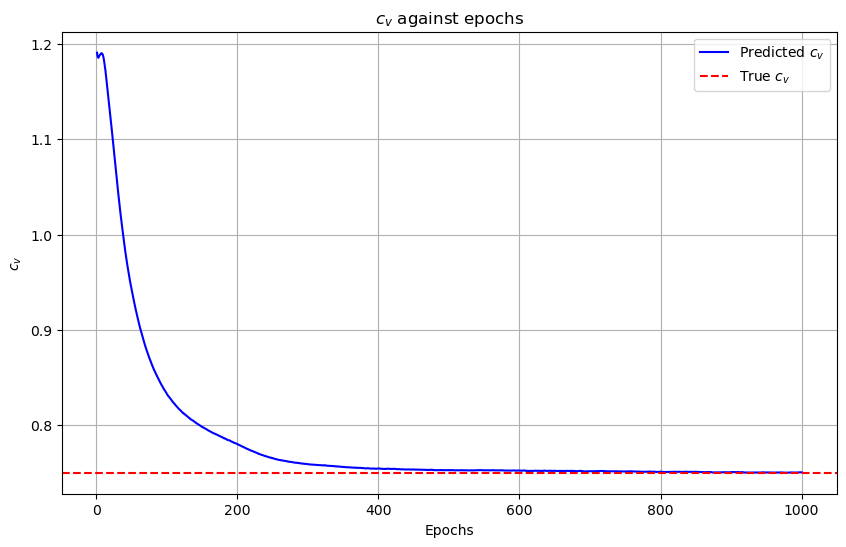

In [7]:
# Ensure 'parameter' contains the history of 'c_v' values
cv_values = H_new.history['cv_inv']
epochs = range(1, len(cv_values) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, cv_values, 'b-', label='Predicted $c_{v}$')
plt.axhline(y=cv, color='r', linestyle='--', label='True $c_{v}$')
plt.xlabel('Epochs')
plt.ylabel('$c_{v}$')
plt.title('$c_{v}$ against epochs')
plt.legend()
plt.grid(True)
plt.savefig("InvertedCv_1D.png", dpi=600)
plt.show()